In [59]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns


In [94]:
def normalize_s3_image(data):
    
    p1, p99 = np.nanpercentile(data.compressed(), [1, 99])
    data = np.clip(data, p1, p99)
    data = (data - p1) / (p99 - p1)
    return data


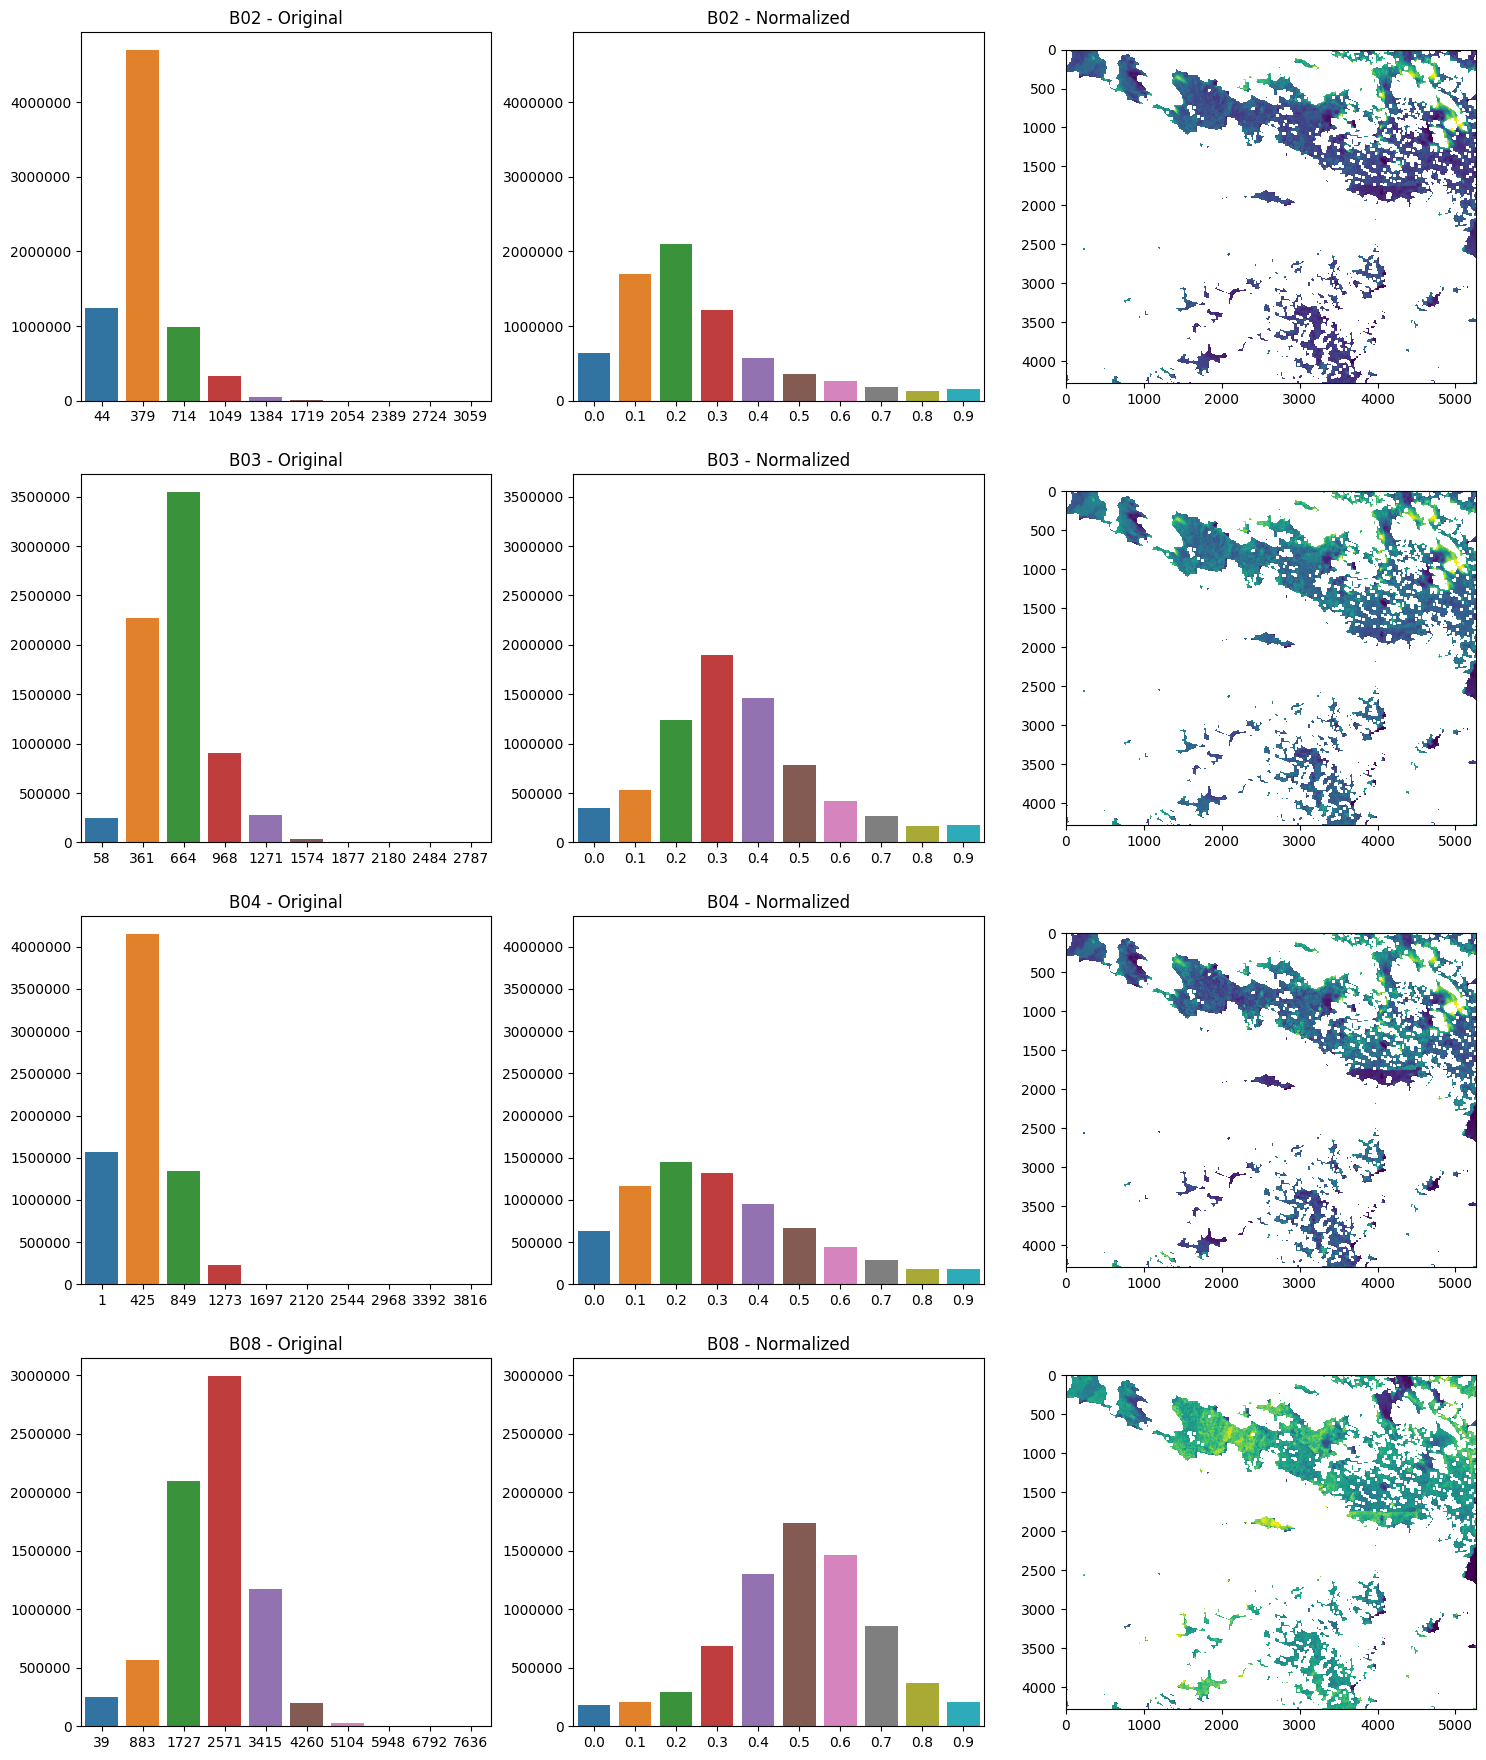

In [102]:
from matplotlib.ticker import FormatStrFormatter

central1 = "./data/20200101_20200301_central/S2A_35MQV_20200123_0_L2A"
central2 = "./data/20200101_20200301_central/S2B_35MQV_20200207_0_L2A"
south1 = "./data/20200101_20200301_south/S2B_35MQU_20200207_0_L2A"
south2 = "./data/20200101_20200301_south/S2B_35MQU_20200217_0_L2A"

scenes = [central1, central2, south1, south2]


bands = ['B02', 'B03', 'B04', 'B08']

fig, rows = plt.subplots(4, 3, figsize=(18, 22))

for i, band in enumerate(bands):
        
    band_path = f'{south2}/{band}_masked.tif'
    with rasterio.open(band_path) as src:
        og_data = src.read(1, masked=True)

    row = rows[i]
    og_hist, og_edges = np.histogram(og_data.compressed(), bins=10)
    og_plot = sns.barplot(x=og_edges[:-1], y=og_hist, ax=row[0])

    og_texts = [t.get_text() for t in og_plot.get_xticklabels()]
    og_ticks = [str(round(float(t))) for t in og_texts]
    og_plot.set_xticklabels(og_ticks)
    row[0].set_title(f'{band} - Original')    
    row[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))

    norm_data = normalize_s3_image(og_data)
    
    norm_hist, norm_edges = np.histogram(norm_data.compressed(), bins=10)
    norm_plot = sns.barplot(x=norm_edges[:-1], y=norm_hist, ax=row[1])
    norm_texts = [t.get_text() for t in norm_plot.get_xticklabels()]
    norm_ticks = [str(round(float(t), 2)) for t in norm_texts]
    norm_plot.set_xticklabels(norm_ticks)
    row[1].set_ylim(row[0].get_ylim())
    row[1].set_title(f'{band} - Normalized')    
    row[1].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    row[2].imshow(norm_data)
    
plt.show()


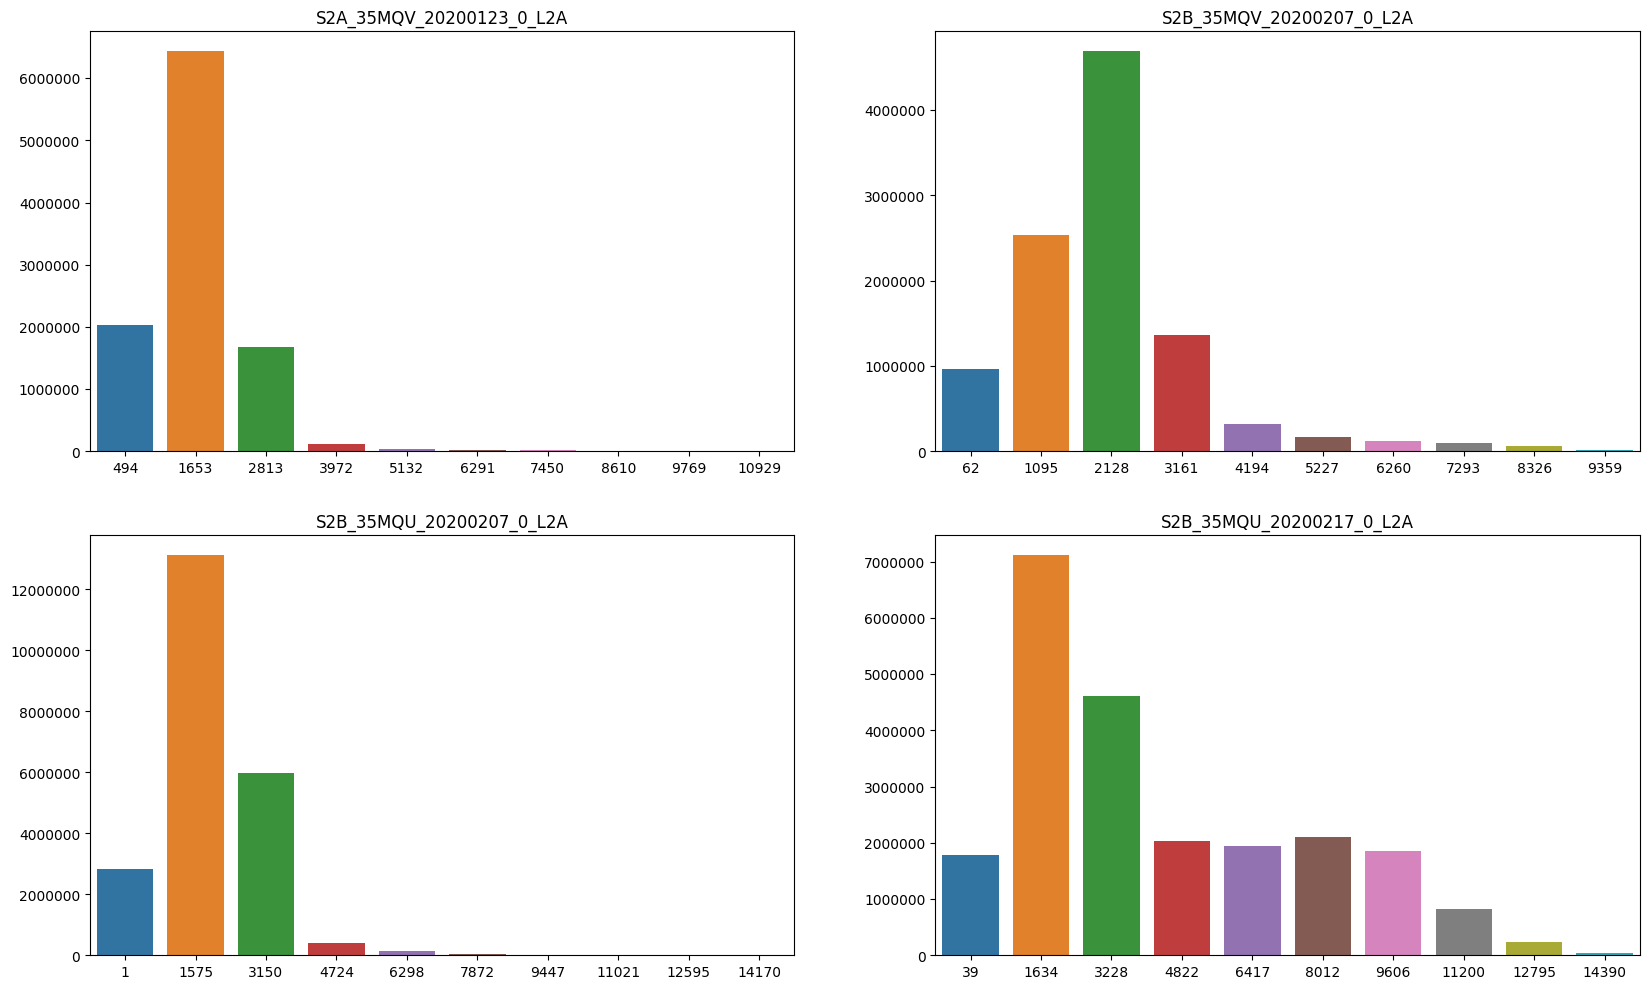

In [57]:
scenes = [central1, central2, south1, south2]

bands = ['B02', 'B03', 'B04', 'B08']

fig, rows = plt.subplots(2, 2, figsize=(20, 12))

for i, scene_path in enumerate(scenes):
    
    scene = scene_path.split('/')[3]
    band_path = f'{scene_path}/B08.tif'
    with rasterio.open(band_path) as src:
        band_data = src.read(1, masked=True)
        hist, edges = np.histogram(band_data, bins=10)
        
    row = i // 2
    col = i % 2
    axis = rows[row][col]
    barplot = sns.barplot(x=edges[:-1], y=hist, ax=axis)
    texts = [t.get_text() for t in barplot.get_xticklabels()]
    ticks = [str(round(float(t))) for t in texts]
    barplot.set_xticklabels(ticks)
    axis.set_title(scene)
    axis.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    